### Environment Setup

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from numpy.linalg import inv
from scipy import interpolate

from scipy.optimize import minimize
from sklearn.metrics import r2_score

%matplotlib inline

### Downloading File

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-717038285/sub-717038285_ses-732592105.nwb"
# dandiset_id = "000563"
# dandi_filepath = "sub-688546/sub-688546_ses-1295360519.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.59.1) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### The GLM

In [5]:
def neg_log_lik_lnp(theta, X, y):
  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  return -log_lik

In [6]:
def fit_lnp(X, y, d=25):
  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)
  print("y:",y.shape,"X:",X.shape,"x0:",x0.shape)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y))

  return res["x"][0], res["x"][1:]

### Fake Data

0.0 5.0
2500


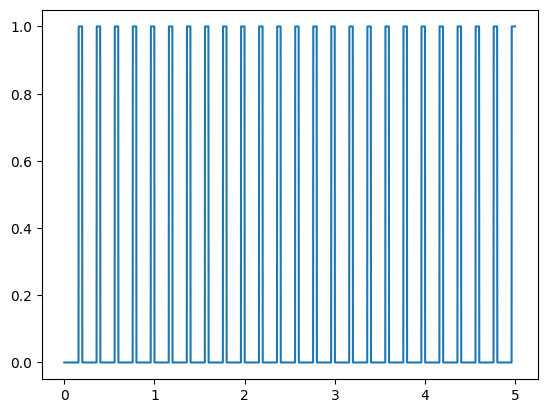

In [7]:
def make_flashes(time_start, time_end, pattern, n_repeats):
    flashes = np.tile(pattern, n_repeats)
    time_axis = np.linspace(time_start, time_end, len(flashes))
    return time_axis, flashes

time_axis, syn_flashes = make_flashes(0, 5, [0]*80 + [1]*20, 25)
print(time_axis[0], time_axis[-1])
print(len(syn_flashes))
plt.plot(time_axis, syn_flashes)

2500


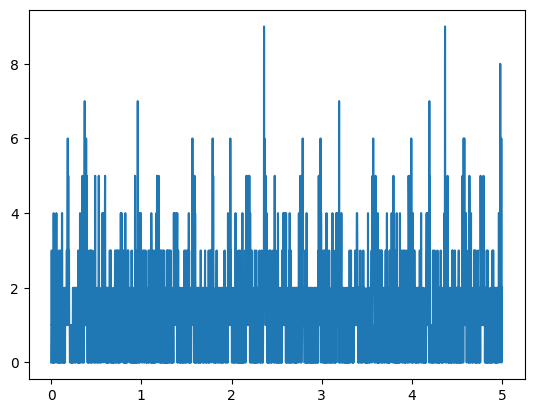

In [8]:
def make_spikes(stim, baseline_rate, coeff, return_exp=False):
    weighted_stim = (stim*coeff) + baseline_rate
    exp_stim = np.exp(weighted_stim)
    spikes = np.random.poisson(exp_stim)
    if return_exp:
        return spikes[1:], weighted_stim, exp_stim
    return spikes

syn_spikes_binned = make_spikes(syn_flashes, 0.05, 0.95)
print(len(syn_spikes_binned))
plt.plot(time_axis, syn_spikes_binned)

### Design Matrix

In [9]:
def build_design_mat(stim, d):
  constant = np.ones_like(stim)

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  design_matrix = np.column_stack([constant, X])
  return design_matrix

(2500, 26)


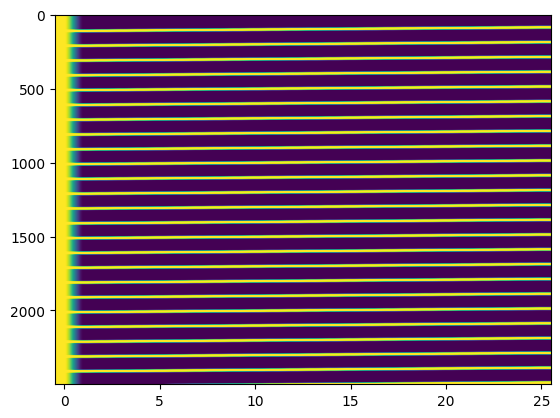

In [10]:
design_mat = build_design_mat(syn_flashes, 25)
print(design_mat.shape)
plt.imshow(design_mat, aspect="auto")

### Running on Synthetic Data

y: (2500,) X: (2500, 26) x0: (26,)
-0.024643724724950924


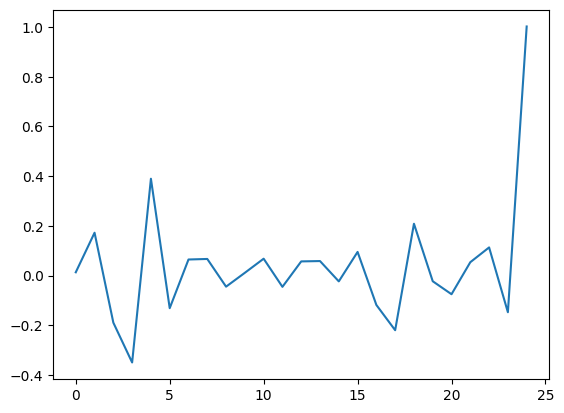

In [11]:
constant, filter = fit_lnp(design_mat, syn_spikes_binned)
print(constant)
plt.plot(filter)

In [12]:
repeats_vals = []
constant_vals = []
filter1_vals = []
for i in range(10):
    for j in range(10):
        n_repeats = 2**i

        time_axis, syn_flashes = make_flashes(0, n_repeats, [0]*80 + [1]*20, n_repeats)
        design_mat = build_design_mat(syn_flashes, d=1)
        syn_spikes_binned = make_spikes(syn_flashes, 0.05, 0.95)

        constant, filter = fit_lnp(design_mat, syn_spikes_binned, d=1)
        repeats_vals.append(n_repeats)
        constant_vals.append(constant)
        filter1_vals.append(filter[0])

y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (100,) X: (100, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (200,) X: (200, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (400,) X: (400, 2) x0: (2,)
y: (800,) X: (800, 2) x0: (2,)
y: (800,) X: (800, 2) x0: (2,)
y: (800,

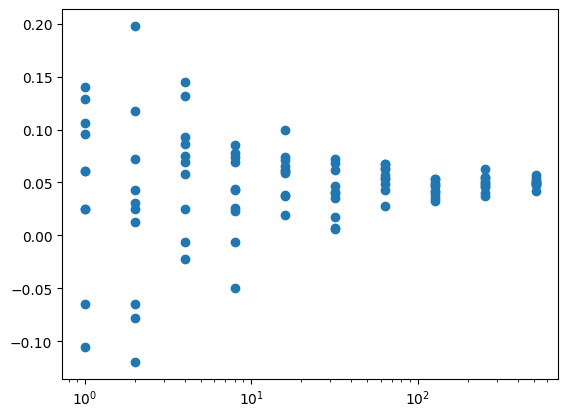

In [13]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.scatter(repeats_vals, constant_vals)

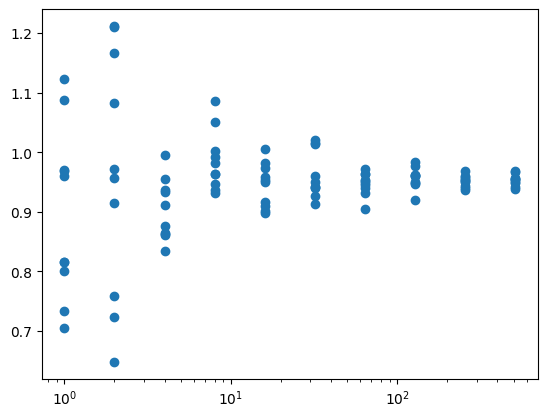

In [14]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.scatter(repeats_vals, filter1_vals)

In [15]:
print(np.mean(filter1_vals[-10:]))
print(np.mean(constant_vals[-10:]))

0.9531312282200037
0.05005331923270586


### Extracting Exogenous Data

2.001673355704697


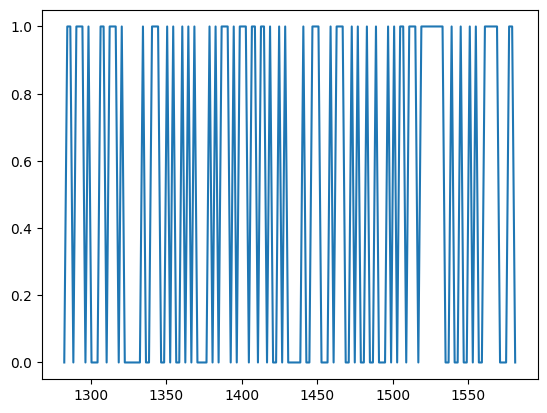

In [16]:
flashes_table = nwb.intervals["flashes_presentations"]
# flashes_table = nwb.intervals["UniqueFFF_presentations"]
# flashes_table[:10]
flashes_times = [float(start_time) for start_time in flashes_table.start_time]
flashes = [1.0 if color=="1.0" else 0 for color in flashes_table.color]

print(np.mean(np.diff(flashes_times)))
plt.plot(flashes_times, flashes)

### Extracting Spike Data

In [17]:
units = nwb.units

In [18]:
### use the electrodes table to devise a function which maps units to their brain regions

# select electrodes
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# function aligns location information from electrodes table with channel id from the units table
def get_unit_location(row):
    return channel_probes[int(row.peak_channel_id)]

print(set(get_unit_location(row) for row in units))

{'', 'VISal', 'VISpm', 'VISl', 'grey', 'VISrl', 'VISp'}


In [19]:
### selecting units spike times

brain_regions = ["VISp"]

# select units based if they have 'good' quality and exists in one of the specified brain_regions
units_spike_times = []
for location in brain_regions:
    location_units_spike_times = []
    for row in units:
        if get_unit_location(row) == location and row.quality.item() == "good":
            location_units_spike_times.append(row.spike_times.item())
    units_spike_times += location_units_spike_times

print(len(units_spike_times))
units_spike_times = units_spike_times[:10]

244


### Aligning Data

In [20]:
bin_sz = 0.01

start_time = max(min([min(times) for times in units_spike_times]), np.min(flashes_times))
end_time = min(max([max(times) for times in units_spike_times]), np.max(flashes_times))
print("start:",start_time,"end:",end_time)

start: 1282.6326142945445 end: 1580.8819442945444


29825


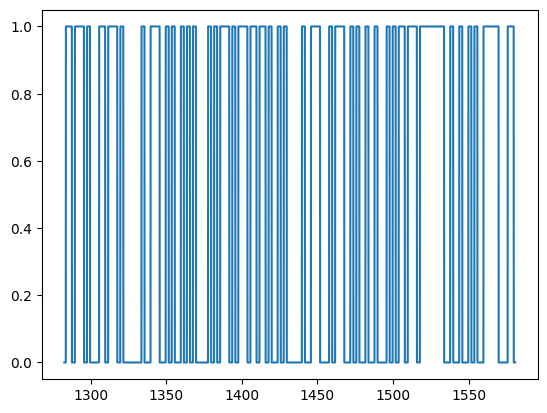

In [21]:
time_axis = np.arange(start_time, end_time, step=bin_sz)

f = interpolate.interp1d(flashes_times, flashes, axis=0, kind="nearest", fill_value="extrapolate")
interp_flashes = f(time_axis)
print(len(interp_flashes))
plt.plot(time_axis, interp_flashes)

### Generating Filters

In [29]:
design_mat = build_design_mat(interp_flashes, d=25)

filters = []
for i, spike_times in enumerate(units_spike_times):
    these_spikes_binned, _ = np.histogram(spike_times, bins=len(time_axis), range=(start_time,end_time))
    # try:
    const, filt = fit_lnp(design_mat, these_spikes_binned)
    filters.append(filt)
    print(i)
    # except:
    #     filters.append([])

y: (29825,) X: (29825, 26) x0: (26,)
0
y: (29825,) X: (29825, 26) x0: (26,)
1
y: (29825,) X: (29825, 26) x0: (26,)
2
y: (29825,) X: (29825, 26) x0: (26,)
3
y: (29825,) X: (29825, 26) x0: (26,)
4
y: (29825,) X: (29825, 26) x0: (26,)
5
y: (29825,) X: (29825, 26) x0: (26,)
6
y: (29825,) X: (29825, 26) x0: (26,)
7
y: (29825,) X: (29825, 26) x0: (26,)
8
y: (29825,) X: (29825, 26) x0: (26,)
9


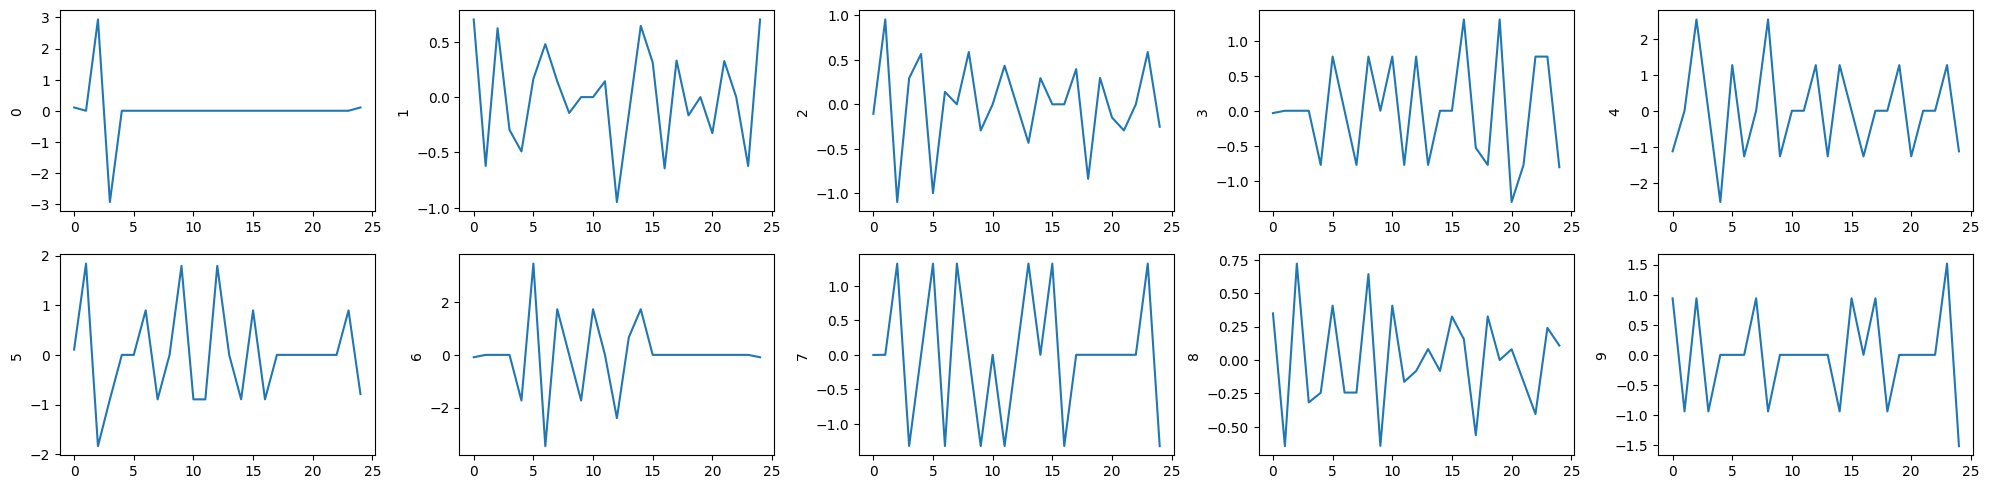

In [30]:
n_cols=5

n_rows = ceil(len(filters)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,5))
if len(axes.shape) == 1:
    axes = axes.reshape((1, axes.shape[0]))

for i in range(len(filters)):
    f = filters[i]
    row = i // n_cols
    col = i % n_cols
    axes[row][col].plot(f)
    axes[row][col].set_ylabel(i)

fig.tight_layout()
plt.show()

In [24]:
unit_idx = 134
spike_times = units_spike_times[unit_idx]
print(spike_times)

IndexError: list index out of range

In [ ]:
num_spikes = len(time_axis)
# spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, time_axis)

### Predict Activity

In [ ]:
ntfilt = 1
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)
design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

res = fit_lnp(design_mat_offset, spikes_binned, bin_sz=0.01, lam=0)
constant, filter = res[0], res[1:]
print(constant, filter)

In [ ]:
def predict(X, weights, constant, bin_sz=1):
    y = np.exp(X @ weights + constant) * bin_sz
    return y

def predict_spikes(X, weights, constant, bin_sz=1):
    rate = predict(X, weights, constant, bin_sz)
    spks = np.random.poisson(np.matrix.transpose(rate))
    return spks

In [ ]:
### predict
predictions = []
for j in range(100):
    predictions.append(predict_spikes(design_mat, filter, constant))

In [ ]:
fig, axes = plt.subplots(1,6, figsize=(30,5))

prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
avg_predicted = np.mean(predictions, axis=0)

axes[0].plot(spikes_binned[0:1000])
axes[1].plot(filter)
axes[2].plot(prob_predicted[0:1000])
axes[3].plot(spikes_predicted[0:1000])
axes[4].plot(avg_predicted[0:1000])
axes[5].plot(spikes_binned[0:1000])
axes[5].plot(spikes_predicted[0:1000])

print(r2_score(spikes_binned, spikes_predicted))
print(np.sum(spikes_binned) / len(spikes_binned))
print(np.sum(spikes_predicted) / len(spikes_predicted))

plt.show()

In [ ]:
mse2 = np.mean((spikes_binned-spikes_predicted)**2)  # mean squared error, with offset
rss = np.mean((spikes_binned-np.mean(spikes_binned))**2)    # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, w/ offset: {:.2f}'.format(1-mse2/rss))